In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf


In [2]:
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.gratings.utils as gutils
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.utils as hutils
import analyze2p.aggregate_datasets as aggr

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%matplotlib notebook

# Plotting

In [4]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
# src dirs
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'


# Source

In [5]:
responsive_test='ROC'
# -----------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
print(responsive_test, responsive_thr)

ori_fit_desc = gutils.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500


# Aggregate meta 

In [6]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


,animalid,session,fovnum
visual_area,,,
Li,16,16,16
Lm,10,10,10
V1,9,9,9


# Output dir

In [15]:
dst_dir = os.path.join(aggregate_dir, 'gratings-tuning', 
                       '%s-%s' % (traceid, ori_fit_desc))

#### Set current output dir
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

# -------------------------------------------------------
FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
print(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/aggregate_metrics
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES


# All fits

In [9]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, 
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['spNeed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(float)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gratings/utils.py:227: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


In [10]:
missing_

['Li_20190319_JC067_fov1', 'Lm_20191111_JC120_fov1', 'V1_20190517_JC083_fov1']

In [11]:
gdata[gdata['gof']>0.5][['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area')['cell'].count()

visual_area
Li     98
Lm    227
V1    444
Name: cell, dtype: int64

In [12]:
gdata[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area')['cell'].count()

visual_area
Li    349
Lm    422
V1    865
Name: cell, dtype: int64

In [13]:
missing_

['Li_20190319_JC067_fov1', 'Lm_20191111_JC120_fov1', 'V1_20190517_JC083_fov1']

#### Filter fits

In [14]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()
# old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
# bestg = p3.split_datakey(bestg)
# bestg = bestg[~bestg.animalid.isin(old_rats)]
# bestg[bestg.visual_area=='Li']['datakey']

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2,...,gof,sf,size,speed,datakey,animalid,fov,session,tf,tested_theta
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,349,349,349,349,349,349,349,349,349,349,...,349,349,349,349,349,349,349,349,349,349
Lm,422,422,422,422,422,422,422,422,422,422,...,422,422,422,422,422,422,422,422,422,422
V1,865,865,865,865,865,865,865,865,865,865,...,865,865,865,865,865,865,865,865,865,865


visual_area
Li     92
Lm    143
V1    284
Name: cell, dtype: int64


<IPython.core.display.Javascript object>


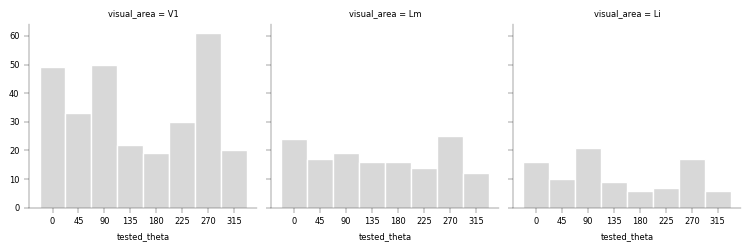

In [16]:
gof_thr=0.5
passg = bestg[(bestg['gof']>gof_thr) & (bestg['dsi']>0.2)].copy()
print(passg.groupby(['visual_area'])['cell'].count())
fg = sns.FacetGrid(passg, col='visual_area', col_order=visual_areas, height=2.5)
fg.map(sns.histplot, 'tested_theta', bins=theta_vals, color=[0.8]*3, edgecolor='w')
axes = fg.fig.axes
for ax in axes:
    ax.set_xticks(tested_thetas+(45/2.))
    ax.set_xticklabels(tested_thetas)

# Get counts of unique datasets

In [17]:
# Unique datasets, get dsets with most ncells pass
min_ncells=0
drop_repeats=True
counts = bestg[bestg['gof']>gof_thr][['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count().reset_index()
# counts = counts[counts['cell']>min_ncells]
u_dkeys = aggr.drop_repeats(counts)   
#counts = hutils.split_datakey(counts)
#unique_dsets = aggr.select_best_fovs(counts, criterion='max', colname='cell')
#u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
all_dkeys = list([tuple(k) for k in \
                  counts[['visual_area', 'datakey']].drop_duplicates().values])
final_dkeys = u_dkeys if drop_repeats else all_dkeys
dset_str = 'drop_repeats' if drop_repeats else 'all_dsets'

FITS = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])\
          if (va, dk) in final_dkeys])
print(FITS[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li               249   249
Lm               411   411
V1               865   865


# All data

In [18]:
trial_epoch='stimulus'
experiment='gratings'
NDATA0 = aggr.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=n_stds)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs


In [19]:
'20190306_JC061_fov2' in gdata['datakey'].unique()

True

In [20]:
NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])
                  if (va, dk) in final_dkeys])

# Counts

In [21]:
ncells_by_fov = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count()\
                        .rename(columns={'cell': 'n_visual'})

nfit_by_fov = FITS[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count()\
                .rename(columns={'cell': 'n_fit'})
gof_thr=0.5
npass_by_fov = FITS[FITS['gof']>gof_thr][['visual_area', 'datakey', 'cell']]\
                .drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count()\
                .rename(columns={'cell': 'n_pass'})

In [22]:
nfits = pd.merge(npass_by_fov, nfit_by_fov, how='outer',
                  left_index=True, right_index=True)\
           .merge(ncells_by_fov, how='outer', left_index=True, right_index=True) 
# totals.groupby('visual_area').describe()

#### Direction selective cells, combine across conds

In [23]:
gof_thr=0.50
min_dsi=0.2

dir_selective_any = FITS[(FITS['dsi']>=min_dsi)].copy()
dir_any_means = dir_selective_any.groupby(['visual_area', 'datakey', 'cell'])\
                        .mean().reset_index()

dir_selective_gof = FITS[(FITS['gof']>=gof_thr) & (FITS['dsi']>=min_dsi)].copy()
# Get means (across non-ori params)
dir_gof_means = dir_selective_gof.groupby(['visual_area', 'datakey', 'cell'])\
                        .mean().reset_index()

#### Axis selective

In [24]:
min_asi = 0.2
axis_selective_any = FITS[(FITS['dsi']<min_dsi) & (FITS['asi']>=min_asi)].copy()
axis_selective_gof = FITS[(FITS['gof']>=gof_thr) 
                     & (FITS['dsi']<min_dsi) & (FITS['asi']>=min_asi)].copy()
# Get means (across non-ori params)
axis_any_means = axis_selective_any.groupby(['visual_area', 'datakey', 'cell'])\
                        .mean().reset_index()
axis_gof_means = axis_selective_gof.groupby(['visual_area', 'datakey', 'cell'])\
                        .mean().reset_index()


In [25]:
dsi_any_counts = dir_selective_any[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count()\
                .rename(columns={'cell': 'dsi_any'})
dsi_gof_counts = dir_selective_gof[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count()\
                .rename(columns={'cell': 'dsi_gof'})

asi_any_counts = axis_selective_any[['visual_area', 'datakey', 'cell']]\
                .drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count()\
                .rename(columns={'cell': 'asi_any'})
asi_gof_counts = axis_selective_gof[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count()\
                .rename(columns={'cell': 'asi_gof'})

dsi_cnts = dsi_any_counts.merge(dsi_gof_counts, how='outer', left_index=True, right_index=True)
asi_cnts = asi_any_counts.merge(asi_gof_counts, how='outer', left_index=True, right_index=True)


In [26]:
totals = nfits.merge(dsi_cnts, how='outer', left_index=True, right_index=True)\
               .merge(asi_cnts, how='outer', left_index=True, right_index=True)
# totals = totals.fillna(value=0)

In [27]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


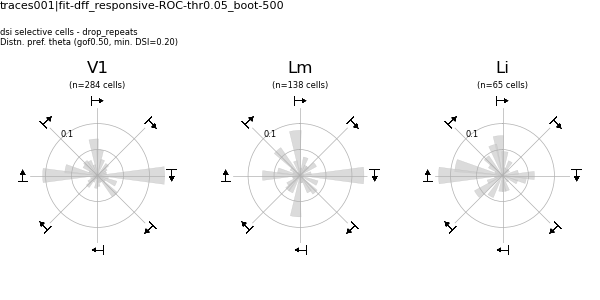

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/aggregate_metrics polar_dsi_gof0.50_dsi0.20


In [39]:
%matplotlib notebook
plot_type = 'dsi'
pass_gof = True

bin_size=12
hist_color=[0.8]*3 #'cornflowerblue'
edge_color=[0.7]*3
alpha=1
bar_width=15.
max_bin = 360 if plot_type=='dsi' else 180
gof_str = 'gof%.2f' % gof_thr if pass_gof else 'allfit'

if plot_type=='asi':
    plotd = axis_selective_gof.copy() if pass_gof else axis_selective_any.copy()
else:
    plotd = dir_selective_gof.copy() if pass_gof else dir_selective_any.copy()

fig = pl.figure(figsize=(6,3))
for va, vg in plotd.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax = fig.add_subplot(1, 3, ai+1, projection="polar")
    # --------------------------------------------------------------------
    degrees = vg['theta_pref'].values % max_bin
    ori_bins = np.arange(0, max_bin+bin_size, bin_size)
    radians = np.rad2deg(degrees)
    weights = np.ones_like(degrees)/len(degrees)
    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins, weights=weights)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=hist_color, alpha=0.7, edgecolor=edge_color, 
               color=hist_color, linewidth=0.2)
    ylim = 0.34 if plot_type=='asi' else 0.13 # bin_counts.max().round(2)
    ytick_lim = np.floor(ylim*10)/10.
    pplot.polar_ticks_gratings(ax, ylim=ylim, ytick_lim=ytick_lim, n_yticks=3)
    ax.set_title('%s' % (va), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % vg.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    ax.spines['polar'].set_visible(False)
    ax.grid(True, linewidth=0.5)
#ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize=fontsize)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.68, wspace=0.5)
fig.text(0.0, 0.85, \
    '%s selective cells - drop_repeats\nDistn. pref. theta (%s, min. DSI=%.2f)'\
    % (plot_type, gof_str, min_dsi))
pplot.label_figure(fig, data_id)

figname = 'polar_%s_%s_dsi%.2f' % (plot_type, gof_str, min_dsi)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(curr_dst_dir, figname)


#### Plot ASI/DSI distns as points

In [838]:
# import pingouin as pg

<IPython.core.display.Javascript object>


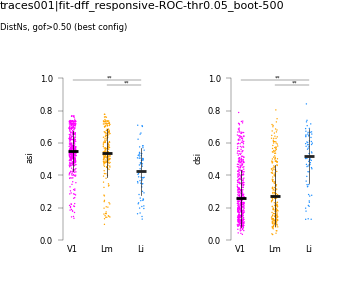

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/aggregate_metrics distns_ASI_DSI_gof0.50_byCELL


In [40]:
%matplotlib notebook
plot_type='byCELL'
mean_type='median'
pass_gof=True

if pass_gof:
    plotd = FITS[FITS['gof']>0.5].copy()
else:
    plotd = FITS.copy()
gof_str = 'gof%.2f' % gof_thr if pass_gof else 'allfit'

# plot
fig, axn = pl.subplots(1,2, figsize=(3.5,3))
for ax, metric in zip(axn.flat, ['asi', 'dsi']):
    pplot.stripplot_metric_by_area(plotd, metric, area_colors=area_colors,
                                markersize=1, ylim=(0, 1.02), ax=ax,
                                sig_fontsize=4, jitter=True, 
                                plot_means=True, y_loc=0.96, offset=0.03,
                                mean_style='point', mean_type=mean_type, aspect=2)
fig.text(0.0, 0.9, 'DistNs, gof>%.2f (best config)' % gof_thr)
pl.subplots_adjust(left=0.12, right=0.97, bottom=0.2, top=0.75, wspace=0.3)

pplot.label_figure(fig, data_id)
figname = 'distns_ASI_DSI_%s_%s' % (gof_str, plot_type)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [841]:
ix_meds = plotd.groupby(['visual_area'])[['asi', 'dsi']].median()\
                .rename(columns={'asi': 'asi_md', 'dsi': 'dsi_md'})
ix_sds = plotd.groupby(['visual_area'])[['asi', 'dsi']].std()\
                .rename(columns={'asi':'asi_sd', 'dsi': 'dsi_sd'})
ix_summary = pd.concat([ix_meds, ix_sds], axis=1)
ix_summary

,asi_md,dsi_md,asi_sd,dsi_sd
visual_area,,,,
Li,0.429646,0.526205,0.144104,0.172931
Lm,0.535080,0.274382,0.149595,0.189547
V1,0.548302,0.253236,0.123417,0.175255


<IPython.core.display.Javascript object>


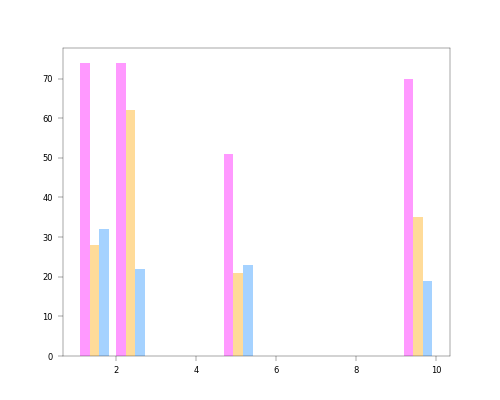

(array([[74., 74.,  0.,  0., 51.,  0.,  0.,  0.,  0., 70.],
        [28., 62.,  0.,  0., 21.,  0.,  0.,  0.,  0., 35.],
        [32., 22.,  0.,  0., 23.,  0.,  0.,  0.,  0., 19.]]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 3 BarContainer objects>)

In [842]:

# sns.displot(x='tf', hue='visual_area', data=passg, ax=ax, kind='hist', 
#             palette=area_colors)
binsize=10
fig, ax = pl.subplots()
mats=[]
for va, g in passg.groupby(['visual_area']):
    mats.append(sorted(g['tf'].values))
mat_labels = sorted(passg['tf'].unique())
ax.hist(mats[::-1], binsize, histtype='bar', color=[area_colors[v] for v in visual_areas],
        align='mid', label=visual_areas, alpha=0.4)#, rwidth=0.6)


In [843]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


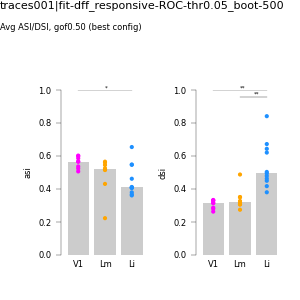

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/aggregate_metrics distns_ASI_DSI_gof0.50_byFOV


In [42]:
%matplotlib notebook
# Plot average across cells, per FOV
plot_type='byFOV'
med_by_fov = plotd.groupby(['visual_area', 'datakey']).mean().reset_index()
bar_color=[0.8]*3

# plot
multi_comp_test='fdr_bh'
fig, axn = pl.subplots(1,2, figsize=(3,3), sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['asi', 'dsi']):
    ylim = (0, 1)
    pplot.stripplot_metric_by_area(med_by_fov, metric, area_colors=area_colors,
                                markersize=3, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=0.96, offset=0.04,
                                mean_style='bar', mean_type=mean_type, aspect=2)
pl.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.7, 
                   wspace=0.5, hspace=0.3)
fig.text(0.0, 0.9, 'Avg ASI/DSI, %s (best config)' % gof_str)

pplot.label_figure(fig, data_id)

figname = 'distns_ASI_DSI_%s_%s' % (gof_str, plot_type)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [34]:
totals = totals.fillna(value=0)

In [35]:
totals['frac_asi_gof'] = totals['asi_gof']/totals['n_pass']
totals['frac_dsi_gof'] = totals['dsi_gof']/totals['n_pass']

totals['frac_asi_any'] = totals['asi_any']/totals['n_fit']
totals['frac_dsi_any'] = totals['dsi_any']/totals['n_fit']

totals['frac_asi'] = totals['asi_gof']/totals['n_fit']
totals['frac_dsi'] = totals['dsi_gof']/totals['n_fit']

totals['frac_fit'] = totals['n_fit']/totals['n_visual']
totals['frac_gof'] = totals['n_pass']/totals['n_visual']

<IPython.core.display.Javascript object>


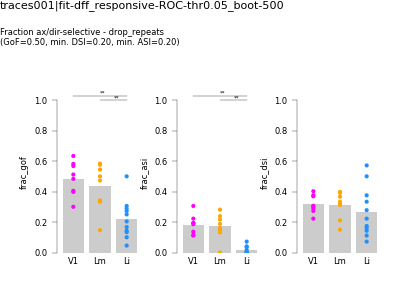

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/aggregate_metrics fraction_selective_gof0.50_dsi0.20_asi0.20


In [43]:
multi_comp_test = 'fdr_bh'
plot_params = ['frac_gof',  'frac_asi','frac_dsi']
fig, axn = pl.subplots(1, 3, sharex=True, sharey=False, figsize=(4,3))
for ax, param in zip(axn.flat, plot_params):
    ylim = (0, 1.05)
    pplot.stripplot_metric_by_area(totals.reset_index(), param, 
                                area_colors=area_colors,
                                markersize=3, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=1.0, offset=0.03,
                                mean_style='bar', mean_type='mean', aspect=2)
#     ax.set_ylim
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.7, 
                   wspace=0.5, hspace=0.3)
fig.text(0.0, 0.85, 
        'Fraction ax/dir-selective - %s\n(GoF=%.2f, min. DSI=%.2f, min. ASI=%.2f)'\
         % (dset_str, gof_thr, min_dsi, min_asi))
pplot.label_figure(fig, data_id)

figname = 'fraction_selective_gof%.2f_dsi%.2f_asi%.2f'\
                % (gof_thr, min_dsi, min_asi)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


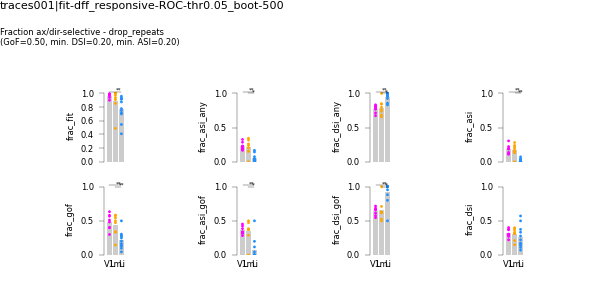

In [38]:
multi_comp_test = 'fdr_bh'
plot_params = ['frac_fit', 'frac_asi_any', 'frac_dsi_any', 'frac_asi',\
               'frac_gof', 'frac_asi_gof', 'frac_dsi_gof', 'frac_dsi']
fig, axn = pl.subplots(2,4, sharex=True, sharey=False, figsize=(6,3))
for ax, param in zip(axn.flat, plot_params):
    ylim = (0, 1.05)
    pplot.stripplot_metric_by_area(totals.reset_index(), param, 
                                area_colors=area_colors,
                                markersize=2, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=1.0, offset=0.02,
                                mean_style='bar', mean_type='mean')
#     ax.set_ylim
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.7, 
                   wspace=0.2, hspace=0.3)
fig.text(0.0, 0.85, 
        'Fraction ax/dir-selective - %s\n(GoF=%.2f, min. DSI=%.2f, min. ASI=%.2f)'\
         % (dset_str, gof_thr, min_dsi, min_asi))
pplot.label_figure(fig, data_id)

# figname = '_fraction_seletive_gof%.2f_dsi%.2f_asi%.2f_%s' % (gof_thr, min_dsi, min_asi, dset_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [44]:
os.path.join(dst_dir, 'final_counts.csv')


'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/final_counts.csv'

In [45]:
final_counts = totals.reset_index()
counts_outfile = os.path.join(dst_dir, 'final_counts.csv')
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/final_counts.csv


# Sparseness

In [46]:
import analyze2p.objects.selectivity as sel

In [47]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [48]:
SDF = aggr.check_sdfs(NDATA0['datakey'].unique(),
                      experiment='gratings', rename=False, return_incorrect=False)

Checking gratings configs


In [49]:
correct_stims = SDF['datakey'].unique()
NDATA1 = NDATA0[NDATA0.datakey.isin(correct_stims)].copy()


In [50]:
[k for k in NDATA0['datakey'].unique() if k not in correct_stims]

['20190314_JC070_fov1',
 '20190315_JC070_fov2',
 '20190319_JC067_fov1',
 '20190321_JC070_fov2',
 '20190522_JC089_fov1',
 '20190527_JC092_fov3',
 '20190306_JC061_fov2',
 '20190512_JC083_fov1',
 '20190513_JC078_fov1',
 '20190517_JC083_fov1',
 '20190511_JC083_fov1']

In [51]:
curr_counts = NDATA1[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')
u_dkeys = aggr.drop_repeats(n_cells_all)
NDATA2 = pd.concat([g for (va, dk), g in NDATA1.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

In [52]:
min_ncells=20
i_=[]
for (va, dk), x0 in NDATA2.groupby(['visual_area', 'datakey']):
    if len(x0['cell'].unique())<min_ncells:
        continue
    rdf0 = x0.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()
    rdf = sel.correct_offset(rdf0, offset='none')
    ixs_ = rdf.groupby(['cell']).apply(sel.assign_sparseness)\
              .rename(columns={0:'sparseness'})
    ixs_['visual_area'] = va
    ixs_['datakey'] = dk
    ixs_['n_cells'] = len(x0['cell'].unique())
    ixs_['cell'] = ixs_.index.tolist()
    i_.append(ixs_.reset_index(drop=True))
sparse = pd.concat(i_, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


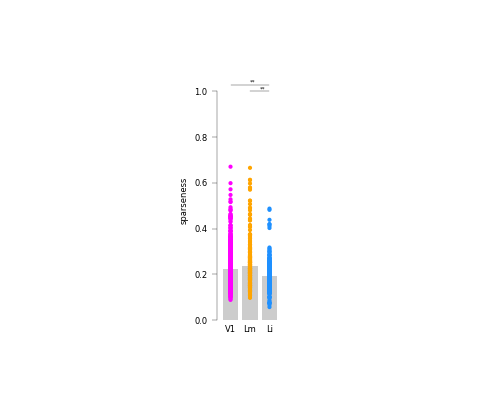

In [53]:
fig, ax = pl.subplots()
ylim = (0, 1.05)
pplot.stripplot_metric_by_area(sparse, 'sparseness', 
                                area_colors=area_colors,
                                markersize=3, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=1.0, offset=0.03,
                                mean_style='bar', mean_type='median', aspect=4)

<IPython.core.display.Javascript object>


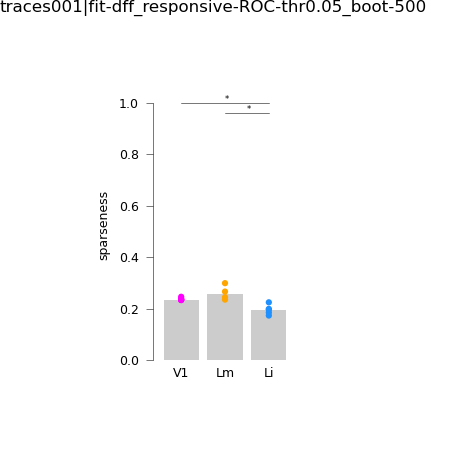

In [58]:
plot_type='byFOV'
fov_df = sparse.groupby(['visual_area', 'datakey']).mean().reset_index()

fig, ax = pl.subplots(figsize=(3,3), dpi=150)
ylim = (0, 1.05)
pplot.stripplot_metric_by_area(fov_df, 'sparseness', 
                                area_colors=area_colors,
                                markersize=3, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=0.96, offset=0.04,
                                mean_style='bar', mean_type='median', aspect=2)
pplot.label_figure(fig, data_id)

In [60]:
cnts = fov_df[['visual_area', 'datakey']].drop_duplicates()\
            .groupby(['visual_area']).count().reset_index()
cnts

,visual_area,datakey
0,Li,5
1,Lm,4
2,V1,6


# Compare with RFs

In [62]:
import analyze2p.decoding as dec

In [409]:
# Load RF data
response_type='dff'
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                       do_spherical_correction=do_spherical_correction)
rfdf = dec.get_rfdf(CELLS, sdata, response_type=response_type,
                       do_spherical_correction=do_spherical_correction)

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4


In [410]:
rfdf['experiment'].unique()

array(['average_rfs'], dtype=object)

In [72]:
assigned_cells, rf_meta = aggr.select_assigned_cells(CELLS, sdata,  
                                  experiments=['rfs', 'rfs10'])
RF0 = rfutils.aggregate_rfdata(rf_meta, assigned_cells, 
                                  fit_desc=rf_fit_desc, 
                                  reliable_only=False, pass_criterion='most')


N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4


In [411]:
RF0.shape, rfdf.shape

((1756, 27), (1484, 27))

In [412]:
r_=[]
for (va, dk), rfs_ in RF0.groupby(['visual_area', 'datakey']):
    if va in ['V1', 'Lm']:
        if 'rfs' in rfs_['experiment'].values:
            r_.append(rfs_[rfs_['experiment']=='rfs'])
    elif va=='Li':
        if 'rfs10' in rfs_['experiment'].values:
            r_.append(rfs_[rfs_['experiment']=='rfs10'])
tmprfs = pd.concat(r_, axis=0, ignore_index=True)
tmprfs.shape

(1229, 27)

In [834]:
# pass_gof=True
# if pass_gof:
#     gfits = FITS[FITS['gof']>0.5].copy()
# else:
#     gfits = FITS.copy()
if pass_gof:
    gfits = bestg[bestg['gof']>0.5].copy()
else:
    gfits = bestg.copy()
gof_str = 'gof%.2f' % gof_thr if pass_gof else 'allfit'

In [835]:
rfs_now = rfdf.copy()
same_col_names = np.intersect1d(gfits.columns.tolist(), rfs_now.columns.tolist())
same_col_names

array(['cell', 'datakey', 'r2', 'visual_area'], dtype='<U15')

In [836]:
rfs_now = rfs_now.rename(columns={'r2': 'r2_rf'})
gfits = gfits.rename(columns={'r2': 'r2_dir'})

merge_cols=['visual_area', 'datakey', 'cell']
GRFS = pd.merge(gfits, rfs_now, on=merge_cols, how='inner')
GRFS.groupby(['visual_area'])['cell'].count()

visual_area
Li     43
Lm     69
V1    232
Name: cell, dtype: int64

In [837]:
gratrf_counts = GRFS.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
gratrf_ukeys = aggr.drop_repeats(gratrf_counts)

finaldf = pd.concat([g for (va, dk), g in GRFS.groupby(['visual_area', 'datakey'])
                  if (va, dk) in gratrf_ukeys])
finaldf['rf_theta_deg'] = [np.rad2deg(i) for i in finaldf['theta_Mm_c'].values]
finaldf[finaldf['gof']>0.5].groupby(['visual_area']).count()

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2_dir,...,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,experiment,rf_theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
Lm,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
V1,232,232,232,232,232,232,232,232,232,232,...,232,232,232,232,232,232,232,232,232,232


In [838]:
finaldf.groupby(['visual_area'])['cell'].count()

visual_area
Li     31
Lm     65
V1    232
Name: cell, dtype: int64

<IPython.core.display.Javascript object>


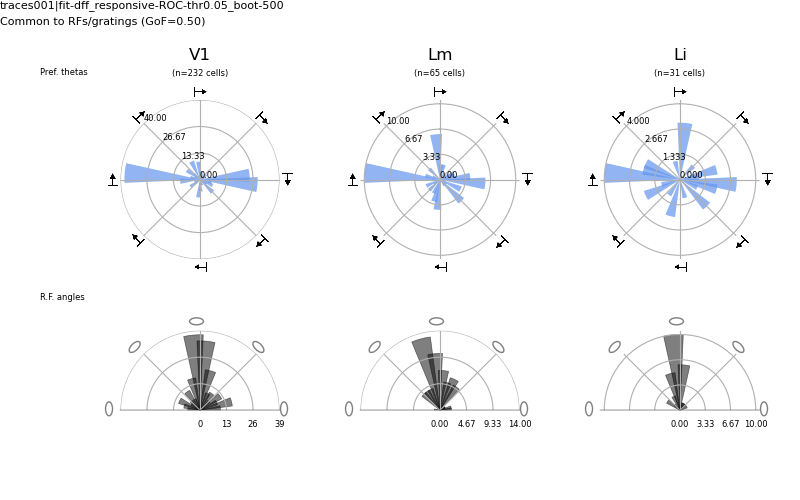

Text(0.0, 0.95, 'Common to RFs/gratings (GoF=0.50)')

In [839]:
gof_thr=0.5
# if pass_gof:
#     plotd = finaldf[finaldf['gof']>gof_thr].copy().dropna()
# else:
plotd = finaldf.copy()
rf_color='k'
ori_color='cornflowerblue'
ell_icon_height = 5
alpha=0.5
bar_width=15.
bin_size = 10
# -----------------------------------------
max_ori = 360.
ori_names = np.arange(0, max_ori+45, 45)
ori_bins = np.arange(0, max_ori+bin_size, bin_size)

rf_names = np.arange(-90, 90+45, 45)
rf_bins = np.arange(-90, 90+bin_size, bin_size)
# plot.
fig = pl.figure(figsize=(8,5))
i=0
for vi, visual_area in enumerate(visual_areas):
    g = plotd[plotd['visual_area']==visual_area].copy()
    # First, do PREFERRED THETA
    degrees = g['theta_pref'].values % max_ori #% 180.
    radians = np.rad2deg(degrees)
    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=ori_color, alpha=0.7, edgecolor="none", 
               color=ori_color, linewidth=0.5)
    ax.set_title('%s' % (visual_area), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % g.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    pplot.replace_ori_labels(ori_names, ax=ax, 
                    xybox=(0, 0), yloc=ax.get_ylim()[-1]*1.1, zoom=0.12, polar=True)
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    # Now, do RECEPTIVE FIELD angles
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.
    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
           color=rf_color, alpha=0.5, edgecolor=rf_color, lw=0.5)
    ax.set_theta_zero_location("N")
    # Set ticks
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))
    i+=2
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.15, wspace=0.5, hspace=0.2, top=0.8,
                   right=0.95, bottom=0.1)

fig.text(0.05, 0.85, "Pref. thetas", horizontalalignment='left', fontsize=6)
fig.text(0.05, 0.4, "R.F. angles", horizontalalignment='left', fontsize=6)
fig.text(0.0, 0.95, "Common to RFs/gratings (GoF=%.2f)" % gof_thr, 
             horizontalalignment='left', fontsize=8)

# figname = 'polar_theta_v_RFangles__gof%.2f_%s' % (gof_thr, dset_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [840]:
import analyze2p.correlations as cr

In [841]:
def smallest_signed_angle(x, y, TAU=360):
    a = (x - y) % TAU
    b = (y - x) % TAU
    return -a if a < b else b

In [842]:
def get_pw_angular_dist(df_, tau=180, in_name='input', out_name='output'):
    col_pairs = list(itertools.combinations(df_['cell'], 2))
    pairdf = pd.DataFrame(['%i_%s' % (a, b) for a, b \
                           in col_pairs], columns=['neuron_pair'])
    pairdf['cell_1'] = [a for a, b in col_pairs]
    pairdf['cell_2'] = [b for a, b in col_pairs]
    pairdf[out_name] = [abs(smallest_signed_angle(\
                              float(df_[df_['cell']==a][in_name]), 
                               float(df_[df_['cell']==b][in_name]), TAU=tau)) \
                        for a, b in col_pairs]
    return pairdf

In [843]:
finaldf['rf_theta_deg'] .min(), finaldf['rf_theta_deg'] .max()

(-88.50529363544527, 89.89884954853972)

In [844]:
df = aggr.add_roi_positions(finaldf.copy())

In [845]:
min_ncells=5
a_=[]
for (va, dk), df_ in df.groupby(['visual_area', 'datakey']):
    if len(df_['cell'].unique())<min_ncells:
        continue
    osi_diff = get_pw_angular_dist(df_, in_name='theta_pref', out_name='pref_theta_diff')
    rf_diff = get_pw_angular_dist(df_, in_name='rf_theta_deg', out_name='rf_angle_diff')
    diffs_ = pd.merge(osi_diff, rf_diff, on=['neuron_pair', 'cell_1', 'cell_2'])
#     adist = cr.get_pw_distance(diffs_, df_, xcoord='ml_pos', ycoord='ap_pos', 
#                              label='cortical_distance')
    adist = cr.get_pw_distance(diffs_, df_, xcoord='x0', ycoord='y0', 
                             label='rf_distance')
    adist['visual_area'] = va
    adist['datakey'] = dk
    adist['n_cells'] = len(df_['cell'].unique())
    a_.append(adist)
angdists = pd.concat(a_, axis=0, ignore_index=True)


In [846]:
#adist.head()
compare_cols = ['pref_theta_diff', 'rf_angle_diff', 
                'rf_distance', 'cortical_distance']

<IPython.core.display.Javascript object>


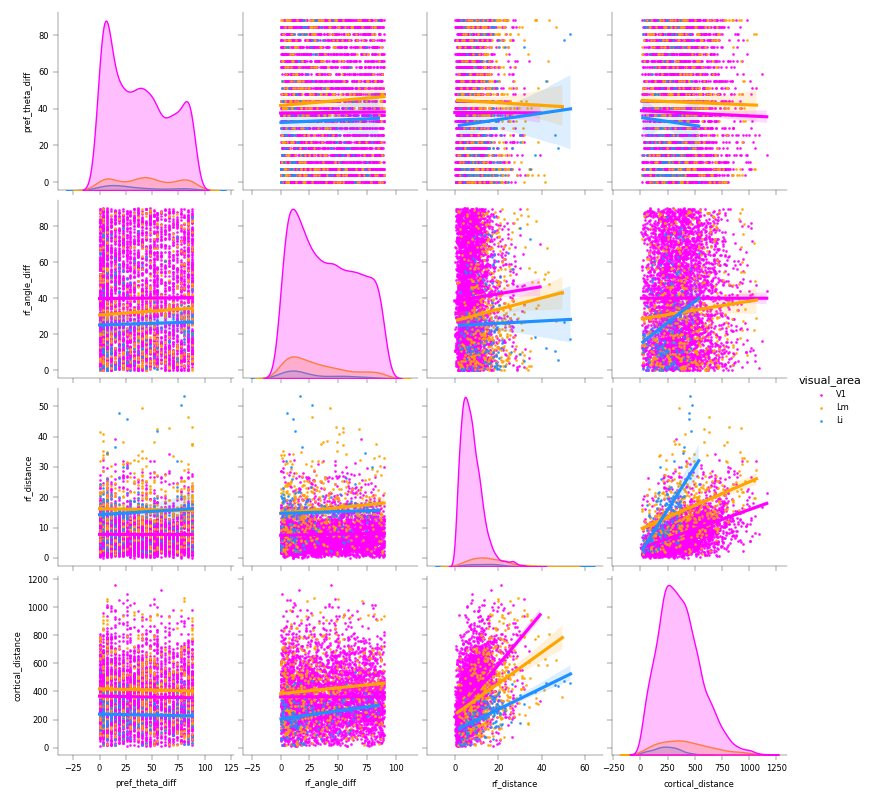

In [847]:
sns.pairplot(angdists, vars=compare_cols, height=2,
            hue='visual_area', palette=area_colors, plot_kws={'scatter_kws': {'s': 1}},
            hue_order=visual_areas, kind='reg')

<IPython.core.display.Javascript object>


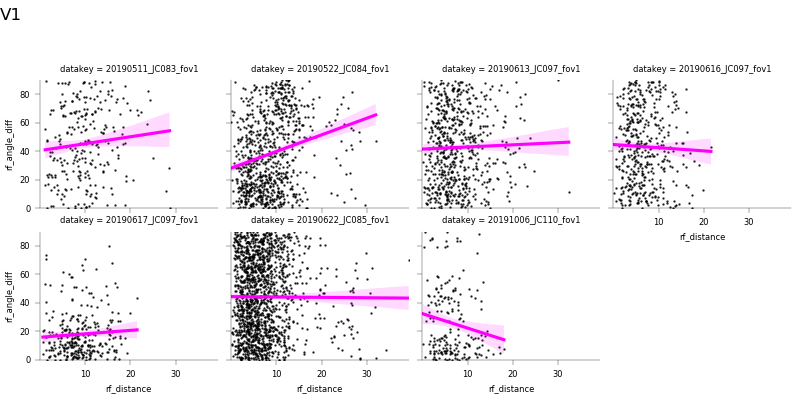

In [848]:
va='V1' 
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='rf_angle_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

<IPython.core.display.Javascript object>


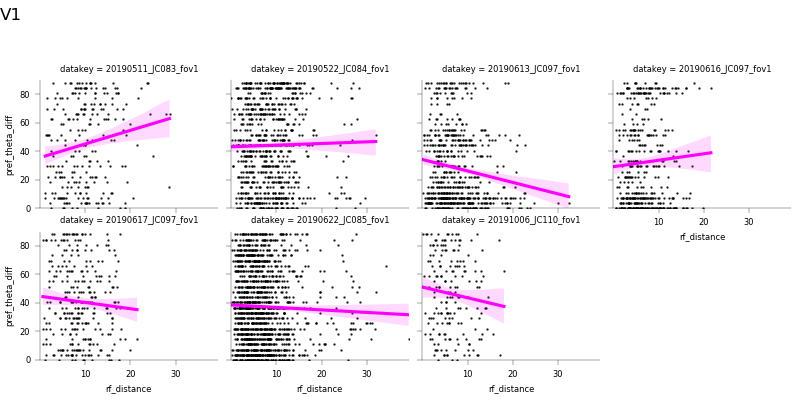

In [849]:
va='V1'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

<IPython.core.display.Javascript object>


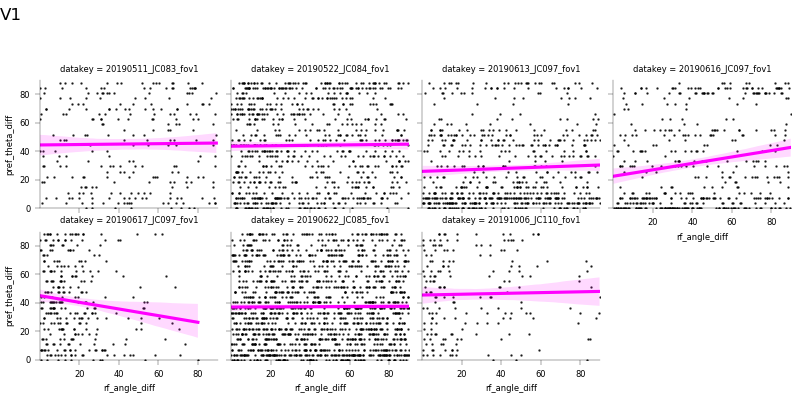

In [850]:
va='V1'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_angle_diff', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

<IPython.core.display.Javascript object>


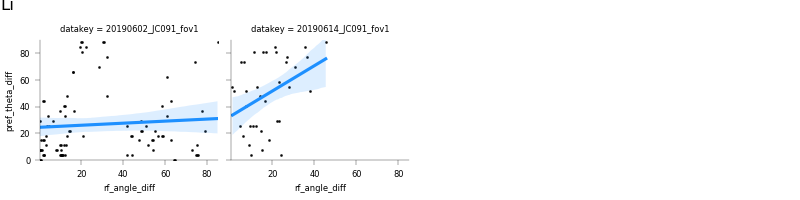

In [851]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_angle_diff', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

<IPython.core.display.Javascript object>


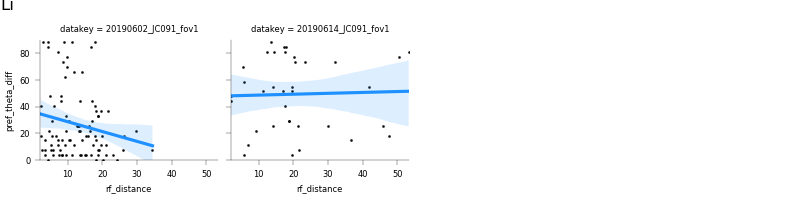

In [852]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

<IPython.core.display.Javascript object>


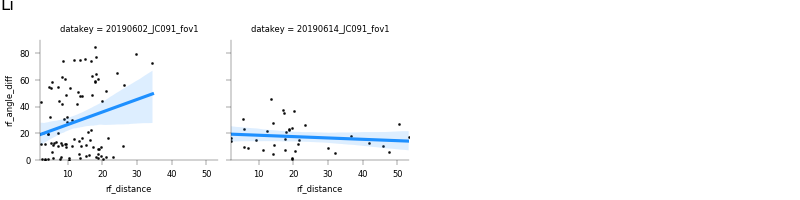

In [853]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='rf_angle_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

In [422]:
def split_by_angle(df_, bin_value, metric='theta_Mm_deg', 
                   boundary_value=180, bin_size=45, combine_zero=True):
    
    ori_bins = np.arange(-boundary_value, boundary_value+bin_size, bin_size)
        
    #angles = (degs + 180.) % (2*180.) - 180.
    half_bin = bin_size/2.

    if bin_value == -boundary_value:
        bmin = boundary_value - half_bin # 90 - 22.5
        bmax = -boundary_value + half_bin  # -90 + 22.5 
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric]<=bmax]
            #n_in_bin = len(angles[angles<=bmax])
    elif bin_value == boundary_value:
        bmin = boundary_value - half_bin
        bmax = -boundary_value + half_bin
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric] >= bmin]
            #n_in_bin = len(angles[angles>=bmin])
    else:
        bmin = bin_value - half_bin
        bmax = bin_value + half_bin
        curr_vs = df_[ (df_[metric] >= bmin) & (df_[metric] <= bmax) ]
        #n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

    #n_in_bin = np.where([angles<])
    #bin_counts.append(n_in_bin)

    return curr_vs #bin_counts, ori_bins

In [336]:
# ori_bin_list = [vi-(45/2.) if vi!=ori_bins[-1] else vi+(45/2.)
#                 for i, vi in enumerate(ori_bins)]
# ori_bin_list

<IPython.core.display.Javascript object>


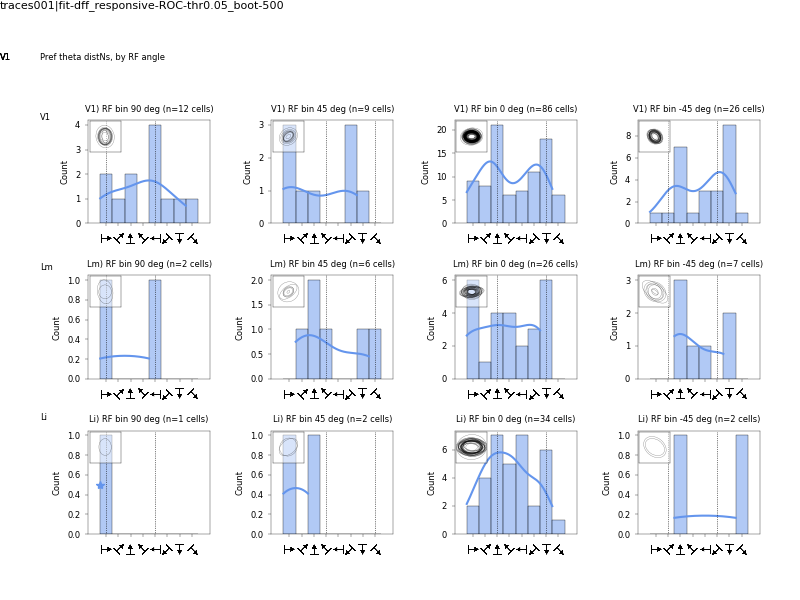

Li:: 65 cells


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Lm:: 72 cells
V1:: 239 cells


In [337]:
rf_color='k'
ori_color='cornflowerblue'

plotd = finaldf.copy()
yloc=0.5
rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=22.5 #22.5 #.5 #22.5
rf_theta_param = 'rf_theta_deg' #'theta_deg'
##### 
bar_width=30
ori_bin_span=22.5 #2.5 #22.5 #22.5
####
aniso_thr=0.1
filter_aniso=False
max_ori=360.
mod_val=360.
n_bins_dist = 8 if max_ori==360. else 4
ori_bins = np.arange(-180, 180+45, 45)
ori_names = np.arange(0, max_ori+45, 45)
label_unit='degrees'
# =====================================================
# PLOT
# =====================================================
fig, axn = pl.subplots(3, len(rf_bins)-1, figsize=(8,6),sharex=True)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.11, right=0.95)
offset=0.25
for va, df_ in plotd.groupby(['visual_area']):
    vi = visual_areas.index(va) #vi, va in enumerate(visual_areas):
    #df_ = DF[(DF['visual_area']==va)].copy()
    print('%s:: %i cells' % (va, df_.shape[0]))
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
    for ci, currbin in enumerate(rf_bins[::-1][0:-1]):   
        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, 
                                 boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]
        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['tested_theta'].values % mod_val
        # RF hists of value
        # ---------------------------------------------------------------------
        ax=axn[vi, ci]
        ax.set_title("%s (%i, %i)" % (va, vi, ci))        
        xticks = np.arange(0, mod_val+45, 45)
        if len(pref_theta_deg)==1:
            ax.plot(pref_theta_deg, yloc, color=ori_color, marker='*')
        #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
        sns.histplot(pref_theta_deg, ax=ax, bins=n_bins_dist, 
                    color=ori_color,
                    kde=True, stat='count', lw=.25, binrange=(0, 360))

        bwidth = np.mean(np.ediff1d(xticks))/2.
        line_loc = ((currbin+90)%360)+bwidth
        ax.axvline(x=line_loc, color='k', lw=0.5, ls=':')
        ax.axvline(x=(line_loc+180)%360., color='k', lw=0.5, ls=':')
        centers = np.ediff1d(xticks)//2 + xticks[:-1]
        ax.set_xticks(centers)
        #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
        pplot.replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), 
                           yloc=-0.15, zoom=0.1, polar=False)
        ax.tick_params(which='both', axis='both', labelsize=6, size=2)
        # RF shapes
        # ---------------------------------------------------------------------
        rect = [0.0, 0.69, 0.28, 0.3]
        ax1 = pplot.add_subplot_axes(ax, rect, axisbg='white', axis_alpha=0.5)
        ax1.set_xlim([-12, 12])
        ax1.set_ylim([-12, 12])
        mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
        for ri in curr_vs.index.tolist():
            rv = curr_vs.loc[ri]
            (sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
            #(sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
            ell = mpl.patches.Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor=rf_color, 
                          facecolor='none', alpha=0.5, lw=0.25)
            ax1.add_patch(ell)
        ax1.set_aspect('equal')
        #ax1.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
        pplot.turn_off_axis_ticks(ax1, despine=False)
        ax.set_title('%s) RF bin %i deg (n=%i cells)' % (va, currbin, ncells), fontsize=6)
        ax.set_xlim([-45, 360+45])
    fig.text(0.05, 0.8-(vi*offset), va)

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
pplot.label_figure(fig, data_id)
    
# figname = 'hist_RFangle_vs_preferredtheta_gof%.2f_%s' % (gof_thr, dset_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# print(curr_dst_dir, figname)

# NON ORI PARAM

In [443]:
# def index_from_samples(sampled_t, sdf=None, paramnames=['sf', 'size', 'speed']):
#     '''
#     For resampled df (rows=trials, cols=configs), calculate preference index
#     for each parameter (sf, size, speed), where 1=prefers bigger, -1=prefers smaller.
#     '''
#     tt = sampled_t.T
#     for p in paramnames:
#         tt[p] = sdf.loc[tt.index][p]
#     # Calculate index
#     trial_cols = [t for t in tt.columns if t not in paramnames]
#     p_ixs={}
#     for p in paramnames:
#         lo, hi = tt[p].unique().min(), tt[p].unique().max()
#         v1 = tt[tt[p]==lo][trial_cols].mean().mean()
#         v2 = tt[tt[p]==hi][trial_cols].mean().mean()
#         ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
#         p_ixs.update({p: ix})
#     return pd.Series(p_ixs)

# def bootstrap_index_calculation(rd, sdf=None, n_bootstrap_iters=100,
#                                paramnames=['sf', 'size', 'speed']):
#     '''Resample trials (w replacement), then calculate preference metric '''
#     # Single value per trial, columns=configs, rows=trial
#     trial_vals = get_trial_df(rd)
#     # Resample and calculate index on each (return Niters x 3)
#     n_resamples=trial_vals.shape[0]
#     iterd = pd.concat([index_from_samples(trial_vals.sample(n_resamples, replace=True), 
#                         sdf=sdf, paramnames=paramnames) \
#                        for _ in range(n_bootstrap_iters)], axis=1).T
#     return iterd



# def bootstrap_and_evaluate_nonori(rd, sdf=None, n_bootstrap_iters=100, alpha=95):
#     '''
#     Use with groupby.apply() for all cells. Does bootstrap analysis for non-ori
#     metrics, then checks for H0 reject or nah
#     '''
#     iterd = bootstrap_index_calculation(rd, sdf=sdf, 
#                             n_bootstrap_iters=n_bootstrap_iters)
#     reject_ = check_null(iterd, alpha=alpha)
#     #reject_['cell'] = float(rd['cell'].unique())
#     return reject_



In [764]:
# def get_trial_df(rd):
#     '''
#     From stacked neuraldf (1 roi's responses), return NtrialxNconfigs df.
#     Add offset for calculating index.
#     '''
#     # Single value per trial, columns=configs, rows=trial
#     trial_vals = pd.concat([pd.Series(g['response'], name=c).reset_index(drop=True)\
#                               for c, g in rd.groupby(['config'])], axis=1)
#     return trial_vals

In [775]:
def calculate_nonori_index(meanr, sdf, offset='minsub', at_best_ori=True):
    '''
    Calculate pref index for SF, SIZE, SPEED.
    meanr: (pd.Series)
        Average response vec to all configs
    offset: str or None ('none', 'minsub', 'rectify')
        How to deal with negative values
    at_best_ori: (bool)
        Only calculate metric at best/most responsive ori 
    Returns:
    ixs: (pd.Series) NEG prefers lower, POS prefers higher
    '''
    if meanr.min()<0 and offset not in ['none', None]:
        if offset=='minsub':
            meanr -= meanr.min()
        elif offset=='rectify':
            meanr[meanr<0] = 0
    if at_best_ori:
        meanr_c = meanr.copy()
        meanr_c.index = sdf.loc[meanr.index]['ori'].values
        best_ori = meanr_c.groupby(meanr_c.index).mean().idxmax()
        sdf_= sdf[sdf['ori']==best_ori].copy()
    else:
        sdf_ = sdf.copy()
        best_ori='all'
    ixs={}
    for par in paramnames:
        v_lo, v_hi = sdf_[par].unique().min(), sdf_[par].unique().max()
        resp_lo = meanr.loc[sdf_[sdf_[par]==v_lo].index].mean()
        resp_hi = meanr.loc[sdf_[sdf_[par]==v_hi].index].mean()
        val = (resp_hi - resp_lo) / (resp_hi+resp_lo)
        ixs.update({par: val})
    ixs.update({'ori': best_ori})
    
    return pd.Series(ixs)

def check_null(iterd, col_order=['sf', 'size', 'speed'], ci=95):
    '''
    Given bootstrapped metrics for sf, size, speed, do 2-tailed test for rejecting null,
    i.e., greater or less than 0 or nah.
    '''
    reject_or_no={}
    lo_ = np.percentile(iterd[col_order], (100-ci)/2, axis=0)
    hi_ = np.percentile(iterd[col_order], ci+((100-ci)/2), axis=0)
    paramcis = [(l, h) for l, h in zip(lo_, hi_)]
    for par, ci_ in zip(col_order, paramcis):
        reject_null = ~(ci_[0] < 0 < ci_[1])
        reject_or_no.update({par: reject_null})
        
    d1 = pd.DataFrame(iterd.median(axis=0), columns=['value'])
    d2 = pd.DataFrame(reject_or_no, index=['reject_null']).T
    df_ = pd.merge(d1, d2, left_index=True, right_index=True)
    df_.index.name = 'param'
    return df_

In [766]:
def count_preference_metrics(test, params=['sf', 'size', 'speed']):
    pref_df=None
    pass_ = test[test.reject_null].copy()
    p_=[]
    for par in params:
        n_pass = pass_[pass_.index.get_level_values('param')==par].shape[0]
        n_total = test.shape[0]
        frac = n_pass/n_total
        # low vs high preference
        pref_lo = pass_[(pass_.index.get_level_values('param')==par) \
                      & (pass_['value']<0)]
        pref_hi = pass_[(pass_.index.get_level_values('param')==par) \
                      & (pass_['value']>0)]
        n_pref_lo = pref_lo.shape[0]
        n_pref_hi = pref_hi.shape[0]
        frac_hi = n_pref_hi/n_pass
        frac_lo = n_pref_lo/n_pass
        prefs_ = pd.DataFrame({'n_pass': n_pass, 'n_total': n_total,
                               'n_pref_low': n_pref_lo, 'n_pref_high': n_pref_hi,
                               'frac_pref': frac, 
                               'frac_pref_low': frac_lo, 'frac_pref_high': frac_hi},
                             index=[par])
        prefs_['param'] = par
        p_.append(prefs_)
    pref_df = pd.concat(p_, axis=0, ignore_index=True)
    return pref_df

In [765]:
def bootstrap_nonori_index(roi_resp, sdf, n_iterations=100, ci=95, 
                           at_best_ori=True,
                           col_order=['sf', 'size', 'speed']):
    if at_best_ori:
        col_order.append('ori')
    trialdf = trial_vals = pd.concat([pd.Series(g['response'], name=c)\
                                      .reset_index(drop=True)\
                              for c, g in roi_resp.groupby(['config'])], axis=1)

    iterd = pd.concat([calculate_nonori_index(\
                    trialdf.sample(n_resamples, replace=True).mean(axis=0), sdf)\
                    for _ in range(n_iterations)], axis=1).T
    res_ = check_null(iterd, col_order=col_order, ci=ci)
    return res_

In [695]:
reject_or_no={}
lo_ = np.percentile(iterd[col_order], (100-ci)/2, axis=0)
hi_ = np.percentile(iterd[col_order], ci+((100-ci)/2), axis=0)
paramcis = [(l, h) for l, h in zip(lo_, hi_)]
for par, ci_ in zip(col_order, paramcis):
    reject_null = ~(ci_[0] < 0 < ci_[1])
    reject_or_no.update({par: reject_null})
reject_or_no

{'sf': True, 'size': True, 'speed': False, 'ori': True}

In [713]:
d1 = pd.DataFrame(iterd.median(axis=0), columns=['value'])
d2 = pd.DataFrame(reject_or_no, index=['reject_null']).T
df_ = pd.merge(d1, d2, left_index=True, right_index=True)


In [455]:
va='V1'
dk = '20190522_JC084_fov1'
sdf = aggr.get_stimuli(dk, experiment='gratings')

ndf = NDATA[(NDATA.datakey==dk) & (NDATA.visual_area==va)].copy()

In [579]:
# rid = 30 # prefers smaller size, SF LOW
rid = 91 # prefers smaller size, SF HIGH
# rid=46
roi_resp = ndf[(ndf['cell']==rid)].copy()
trialdf = get_trial_df(roi_resp)

(20, 64)
(20, 64)


In [580]:
meanr = trialdf.mean(axis=0)
sampler = currt.mean(axis=0)

In [ ]:
n_iterations=500
col_order = ['sf', 'size', 'speed', 'ori']
ci=95


In [703]:
rois_=[30, 91, 46]

In [720]:
# n_iterations=5
# test = ndf[ndf['cell'].isin(rois_)].groupby('cell').apply(bootstrap_nonori_index,\
#                                  n_iterations=n_iterations, ci=ci)

In [730]:
n_iterations=100
test = ndf.groupby('cell').apply(bootstrap_nonori_index,\
                                 n_iterations=n_iterations, ci=ci)

In [763]:
params = ['sf', 'size', 'speed']
pref_df = count_preference_metrics(test, params=params)
pref_df

,n_pass,n_total,n_pref_low,n_pref_high,frac_pref,frac_pref_low,frac_pref_high,param
0,75,516,66,9,0.145349,0.880000,0.120000,sf
1,63,516,56,7,0.122093,0.888889,0.111111,size
2,17,516,5,12,0.032946,0.294118,0.705882,speed


In [771]:
import analyze2p.extraction.traces as traceutils 

In [802]:
import traceback

In [808]:
importlib.reload(gutils)

<module 'analyze2p.gratings.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gratings/utils.py'>

In [809]:
param_list=['sf', 'size', 'speed']

In [810]:
create_new = True 
n_iterations=100
p_list=[]
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    traceid_dir = traceutils.get_traceid_dir(dk, 'gratings', traceid='traces001')
    fitdirs = glob.glob(os.path.join(traceid_dir, 'tuning*', ori_fit_desc))
    if len(fitdirs)==0:
        print("no fits: %s" % dk)
        continue
    fitdir=fitdirs[0]
    tmp_fov_outfile = os.path.join(fitdir, 'results_nonori_params.pkl')
    #if os.path.exists(tmp_fov_outfile):
    #create_new = ~os.path.exists(tmp_fov_outfile)
    if not create_new:
        try:
            with open(tmp_fov_outfile, 'rb') as f:
                ixs_ = pkl.load(f, encoding='latin1')
        except Exception as e:
            print("    err: %s, %s - redoing" % (va, dk))
            create_new=True
            # traceback.print_exc()
    if create_new:
        print("    new (%s, %s)" % (va, dk))
        # Get preference index for all cells in FOV that pass
        ixs_ = ndf.groupby('cell').apply(gutils.bootstrap_nonori_index,\
                                 sdf, param_list=param_list, offset='minsub',
                                 n_iterations=n_iterations, ci=ci)
        # Save iter results
        with open(tmp_fov_outfile, 'wb') as f:
            pkl.dump(ixs_, f, protocol=2)
        print("   saved.")
    # count results
    prefs_ = gutils.count_preference_metrics(ixs_) #, param_list=param_list)
    prefs_['visual_area'] = va
    prefs_['datakey'] = dk
    p_list.append(prefs_)

    new (Li, 20190314_JC070_fov1)
   saved.
    new (Li, 20190315_JC070_fov2)
   saved.
    new (Li, 20190321_JC070_fov2)
   saved.
    new (Li, 20190522_JC089_fov1)
   saved.
    new (Li, 20190602_JC091_fov1)
   saved.
    new (Li, 20190609_JC099_fov1)
   saved.
    new (Li, 20190614_JC091_fov1)
   saved.
    new (Li, 20190617_JC099_fov1)
   saved.
    new (Li, 20191018_JC113_fov1)
   saved.
    new (Li, 20191105_JC117_fov1)
   saved.
    new (Li, 20191111_JC120_fov1)
   saved.
    new (Lm, 20190306_JC061_fov2)
   saved.
    new (Lm, 20190512_JC083_fov1)
   saved.
    new (Lm, 20190513_JC078_fov1)


KeyboardInterrupt: 

In [ ]:

traceid_dir = traceutils.get_traceid_dir(dk, 'gratings', traceid='traces001')
fitdirs = glob.glob(os.path.join(traceid_dir, 'tuning*', ori_fit_desc))
if len(fitdirs)==0:
    print("no fits: %s" % dk)
    continue
fitdir=fitdirs[0]
tmp_fov_outfile = os.path.join(fitdir, 'results_nonori_params.pkl')
if not create_new:
    try:
        with open(tmp_fov_outfile, 'rb') as f:
            ixs_ = pkl.load(f, encoding='latin1')
    except Exception as e:
        print("    err: %s, %s - redoing" % (va, dk))
        create_new=True
        # traceback.print_exc()
if create_new:
    print("    new (%s, %s)" % (va, dk))
    # Get preference index for all cells in FOV that pass
    ixs_ = ndf.groupby('cell').apply(gutils.bootstrap_nonori_index,\
                             sdf, param_list=param_list, offset='minsub',
                             n_iterations=n_iterations, ci=ci)

In [753]:
pref_lo = pass_[(pass_.index.get_level_values('param')==par) & (pass_['value']<0)]
pref_hi = pass_[(pass_.index.get_level_values('param')==par) & (pass_['value']>0)]


,,value,reject_null
cell,param,,
75,speed,-0.220543,True
106,speed,-0.383968,True
126,speed,-0.288320,True
138,speed,-0.248497,True
234,speed,-0.529561,True


<IPython.core.display.Javascript object>


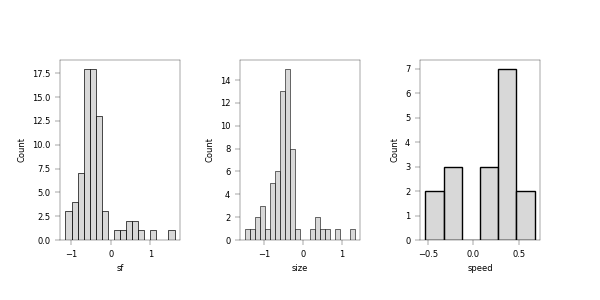

In [747]:
plot_params = ['sf', 'size', 'speed']

fig, axn = pl.subplots(1, len(plot_params), figsize=(6,3))
for ai, (ax, par) in enumerate(zip(axn.flat, plot_params)):
    currd_ = pass_[pass_.index.get_level_values('param')==par]
    sns.histplot(x='value', data=currd_, ax=ax,
                 color=[0.8]*3)
    ax.set_xlabel(par)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.5)

In [742]:
pass_[pass_.index.get_level_values('param')=='ori']

,,value,reject_null
cell,param,,
1,ori,90.0,True
4,ori,0.0,True
5,ori,0.0,True
6,ori,135.0,True
9,ori,90.0,True
...,...,...,...
246,ori,180.0,True
250,ori,90.0,True
252,ori,180.0,True


In [667]:
col_order = ['sf', 'size', 'speed', 'ori']
ci=95
reject_or_no={}
lo_ = np.percentile(iterd[col_order], (100-ci)/2, axis=0)
hi_ = np.percentile(iterd[col_order], ci+((100-ci)/2), axis=0)
paramcis = [(l, h) for l, h in zip(lo_, hi_)]
for par, ci_ in zip(paramnames, paramcis):
    reject_null = ~(ci_[0] < 0 < ci_[1])
    reject_or_no.update({par: reject_null})

lo_ = np.percentile(iterd[col_order], (100-ci)/2, axis=0)
hi_ = np.percentile(iterd[col_order], ci+((100-ci)/2), axis=0)
cis_ = pd.DataFrame(paramcis, index=col_order,
             columns=['lower', 'upper'])
cis_

,lower,upper
sf,0.419763,1.096330
size,-1.515871,-0.982113
speed,-0.587927,0.368633
ori,0.000000,180.000000


<IPython.core.display.Javascript object>


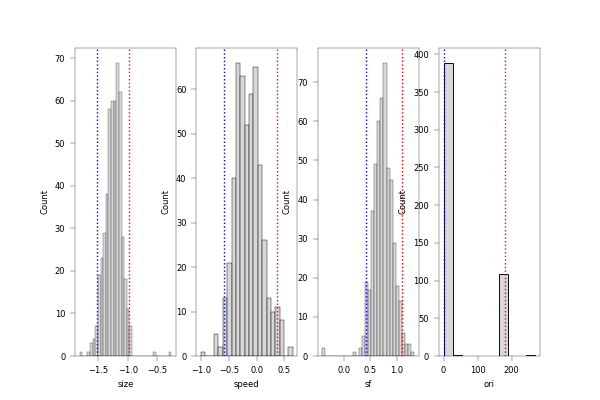

0 size
1 speed
2 sf
3 ori


In [650]:
lw=1
fig, axn = pl.subplots(1, cis_.shape[0], figsize=(6,4))
for pi, (p, vals) in enumerate(iterd.iteritems()):
    ax=axn[pi]
    print(pi, p)
    sns.histplot(x=vals,ax=ax, color=[0.8]*3)
    ax.axvline(x=cis_.loc[p]['upper'], color='r', lw=lw, ls=':')
    ax.axvline(x=cis_.loc[p]['lower'], color='b', lw=lw, ls=':')


In [9]:
# def bootstrap_nonori(rd, n_bootstrap_iters=1000):
#     # Single value per trial, columns=configs, rows=trial
#     trial_vals = pd.concat([pd.Series(g['response'], name=c).reset_index(drop=True)\
#                               for c, g in rd.groupby(['config'])], axis=1)
#     # Resample (Nconfigs x Niters)
#     n_resamples=trial_vals.shape[0]
#     bootdf = pd.concat([trial_vals.sample(n_resamples, replace=True)\
#                         .mean(axis=0) for ni in range(n_bootstrap_iters)], axis=1)
#     d_=[]
#     for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#         iter_vals = bootdf.loc[g['config'].unique()].mean(axis=0) # avg across oris
#         df_ = pd.DataFrame(iter_vals, columns=['response'])
#         df_['size'] = sz
#         df_['sf'] = sf
#         df_['speed'] = sp
#         d_.append(df_)
#     iters = pd.concat(d_, axis=0)
#     return iters

# def is_reliable_or_no(rd, iters):
#     reliable_=[]
#     for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#         iter_vs = iters[(iters['size']==sz) & (iters['sf']==sf) & (iters['speed']==sp)]
#         ordered = sorted(iter_vs['response'])
#         ci_lower = np.percentile(ordered, (100-alpha)/2)
#         ci_upper = np.percentile(ordered, alpha+((100-alpha)/2))
#         true_v =float(g['response'].mean())
#         r_val = ci_lower>0 and (ci_lower<true_v<ci_upper)
#         reliable_.append(r_val)
#     return any(reliable_)

# def test_reliable(rd):
#     iters = bootstrap_nonori(rd)
#     is_r = is_reliable_or_no(rd, iters)
#     return is_r

In [184]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=responsive_thr)
old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
NDATA = p3.split_datakey(NDATA)
NDATA = NDATA[~NDATA.animalid.isin(old_rats)]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [189]:
paramnames = ['size', 'speed', 'sf']
n_bootstrap_iters=100
outfile = os.path.join(curr_dst_dir, 'nonori_params.pkl')
calculate_nonori=False
try:
    with open(outfile, 'rb') as f:
        NON = pkl.load(f)
except Exception as e:
    print("Unable to load saved NON-ori calculations\n%s" % outfile)
    calculate_nonori=True
    

In [190]:
if calculate_nonori:
    R_=[]
    for (va, dk), rdf in NDATA.groupby(['visual_area', 'datakey']):
        sdf = p3.get_stimuli(dk, 'gratings')
        for p in paramnames:
            rdf[p] = sdf.loc[rdf['config']][p].values
        R = rdf.groupby('cell').apply(bootstrap_and_evaluate_nonori, sdf=sdf, 
                                      n_bootstrap_iters=n_bootstrap_iters)
        pass_ = R[R.any(axis=1)]
        pass_['cell'] = pass_.index
        pass_['visual_area'] = va
        pass_['datakey'] = dk
        #reliable_rois = rdf.groupby(['cell']).apply(test_reliable)
        #pass_ = reliable_rois[reliable_rois==True].index.tolist()
        print('%s %s (%i/%i)' % (va,dk, len(pass_), len(rdf['cell'].unique())))
        R_.append(pass_)
    NON = pd.concat(R_, axis=0)
    # save
    with open(outfile, 'wb') as f:
        pkl.dump(NON, f, protocol=2)

In [191]:
NON[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,225,225
Lm,497,497
V1,791,791


## Caculate preference index for cells that pass

In [192]:
def calculate_nonori_index(rd, param='sf'):
    vmin = rd['response'].min()
    if vmin < 0:
        rd['response'] = rd['response'] - vmin
    lo, hi = rd[param].unique().min(), rd[param].unique().max()
    v1 = rd[rd[param]==lo]['response'].mean() 
    v2 = rd[rd[param]==hi]['response'].mean() 
    ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
    return ix #pd.Series(ix) #, index=[rid])

def calculate_nonori_index_all(rd, paramnames=['size', 'speed', 'sf']):
    vmin = rd['response'].min()
    if vmin < 0:
        rd['response'] = rd['response'] - vmin
    p_ixs={}
    for p in paramnames:
        lo, hi = rd[p].unique().min(), rd[p].unique().max()
        v1 = rd[rd[p]==lo]['response'].mean() 
        v2 = rd[rd[p]==hi]['response'].mean() 
        ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
        p_ixs.update({p: ix})
    return pd.Series(p_ixs) #, index=[rid])

In [193]:
# def calculate_index_fov(rdf, paramnames=['sf', 'size', 'speed']):
#     x_=[]
#     for param in paramnames:
#         ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
#         ixs_ = pd.DataFrame(ixs0, columns=['value'])
#         ixs_['metric'] = param
#         ixs_['cell'] = ixs_.index
#         x_.append(ixs_.reset_index(drop=True))
#     curr_ixs = pd.concat(x_, axis=0).reset_index(drop=True)
#     return curr_ixs

def calculate_index_fov(rdf, sdf, param='sf'):
    rdf[param] = sdf.loc[rdf['config']][param].values
    # Get preference index for all cells in FOV that pass
    #ixs_ = calculate_index_fov(rdf, paramnames=paramnames)
    ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
    ixs_ = pd.DataFrame(ixs0, columns=['value'])
    ixs_['metric'] = param
    ixs_['cell'] = ixs_.index.tolist()
    return ixs_

In [194]:

def aggregate_nonori_index(NDATA, NON, param='sf'):
    i_=[]
    for (va, dk), g in NON.groupby(['visual_area', 'datakey']):
        pass_ = g[g[param]]['cell'].unique()
        rdf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)
                   & (NDATA['cell'].isin(pass_))].copy()
        # Assign stimulus info
        sdf = p3.get_stimuli(dk, 'gratings')
        # Get preference index for all cells in FOV that pass
        ixs_ = calculate_index_fov(rdf, sdf, param=param)
        #ixs_ = rdf.groupby(['cell']).apply(calculate_nonori_index)
        ixs_['visual_area'] = va
        ixs_['datakey'] = dk
        i_.append(ixs_)
    ixs = pd.concat(i_, axis=0)
    return ixs

In [195]:
p_=[]
for param in paramnames:
    param_ixs = aggregate_nonori_index(NDATA, NON, param=param)
    p_.append(param_ixs)
ixs = pd.concat(p_)

In [196]:
ixs.head()

,value,metric,cell,visual_area,datakey
cell,,,,,
108,0.0,size,108.0,Li,20190522_JC089_fov1
115,0.0,size,115.0,Li,20190522_JC089_fov1
117,0.0,size,117.0,Li,20190522_JC089_fov1
122,0.0,size,122.0,Li,20190522_JC089_fov1
128,0.0,size,128.0,Li,20190522_JC089_fov1


In [197]:
# Get unique datasets by N cells
curr_counts = ixs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
curr_counts = p3.split_datakey(curr_counts)
unique_dsets = p3.select_best_fovs(curr_counts, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
nonori_df = pd.concat([g for (va, dk), g in \
                    ixs.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in final_dkeys])

In [198]:
nonori_df[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,153,153
Lm,486,486
V1,753,753


In [200]:
nonori_df.head()

,value,metric,cell,visual_area,datakey
cell,,,,,
108,0.0,size,108.0,Li,20190522_JC089_fov1
115,0.0,size,115.0,Li,20190522_JC089_fov1
117,0.0,size,117.0,Li,20190522_JC089_fov1
122,0.0,size,122.0,Li,20190522_JC089_fov1
128,0.0,size,128.0,Li,20190522_JC089_fov1


<IPython.core.display.Javascript object>


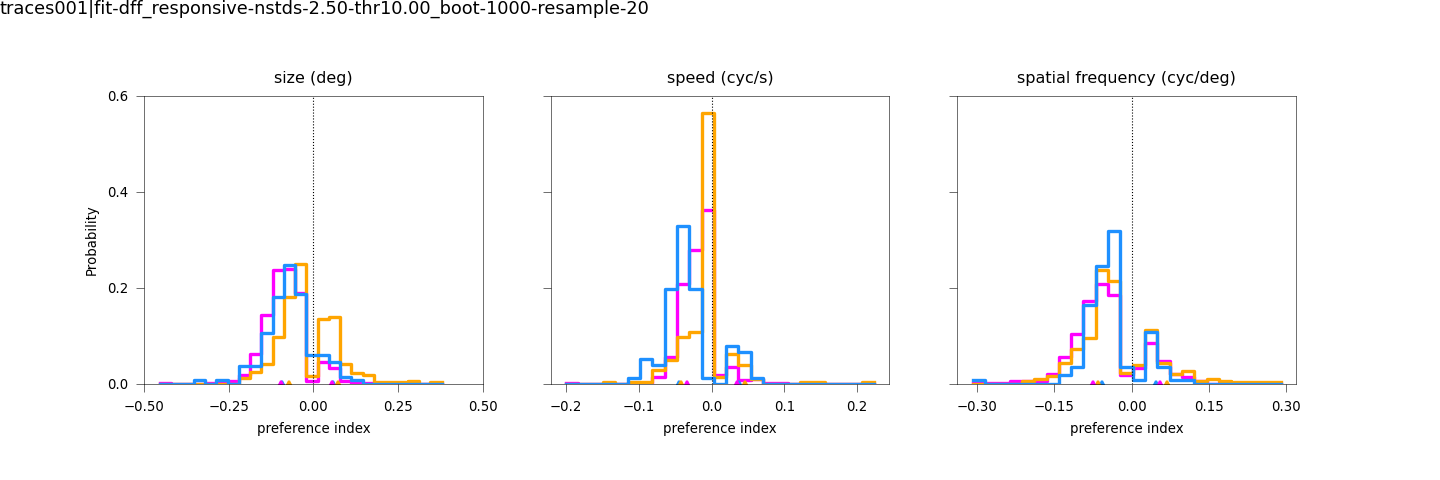

In [304]:
plot_type='stephist'
fig, axn = pl.subplots(1, len(paramnames), sharey=True, figsize=(9,3))
for ax, p in zip(axn.flat, paramnames):
    df_ = nonori_df[nonori_df['metric']==p].copy()
    sns.histplot(x='value', data=df_, 
                 hue='visual_area', palette=area_colors, ax=ax, bins=25,
                  stat='probability', common_norm=False, fill=False,
                element='step')#,
                 #multiple="stack")
    for va, vg in df_.groupby(['visual_area']):
        ax.plot(vg[vg['value']<0]['value'].mean(), -0.0, 
                marker='^', color=area_colors[va], markersize=3)
        ax.plot(vg[vg['value']>0]['value'].mean(), -0.0, marker='^', 
                color=area_colors[va], markersize=3)

    ax.axvline(x=0,color='k', lw=0.5, ls=':')
    ax.set_title(p)
    ax.legend_.remove()
    if p=='size':
        ax.set_title('size (deg)')
        ax.set_xticks(np.linspace(-0.5, 0.5, 5))
    elif p=='speed':
        ax.set_title('speed (cyc/s)')
        ax.set_xticks(np.linspace(-0.2, 0.2, 5))
    else:
        ax.set_title('spatial frequency (cyc/deg)')
        ax.set_xticks(np.linspace(-0.3, 0.3, 5))
    ax.set_ylim((0, 0.6))
    ax.set_yticks(np.linspace(0, 0.6, 4))
    ax.set_yticklabels([round(i, 1) for i in np.linspace(0, 0.6, 4)])
    ax.set_xlabel('preference index')
        
    #sns.despine(trim=True, offset=-2, left=False)
pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8)
pplot.label_figure(fig, data_id)

figname = 'nonori_distns_%s_%s' % (plot_type, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [269]:
nonori_counts = nonori_df[['visual_area', 'datakey', 'cell', 'metric']].drop_duplicates()\
                    .groupby(['metric', 'visual_area', 'datakey']).count().reset_index()
nonori_counts.index = ['%s_%s' % (va, dk) for (va, dk) \
                      in nonori_counts[['visual_area', 'datakey']].values]

In [271]:
nonori_counts[nonori_counts['metric']=='sf']

,metric,visual_area,datakey,cell
Li_20190522_JC089_fov1,sf,Li,20190522_JC089_fov1,4
Li_20190602_JC091_fov1,sf,Li,20190602_JC091_fov1,39
Li_20190612_JC099_fov1,sf,Li,20190612_JC099_fov1,17
Li_20190614_JC091_fov1,sf,Li,20190614_JC091_fov1,30
Li_20191018_JC113_fov1,sf,Li,20191018_JC113_fov1,20
Lm_20190512_JC083_fov1,sf,Lm,20190512_JC083_fov1,73
Lm_20190513_JC078_fov1,sf,Lm,20190513_JC078_fov1,83
Lm_20190525_JC084_fov1,sf,Lm,20190525_JC084_fov1,43
Lm_20190603_JC080_fov1,sf,Lm,20190603_JC080_fov1,62
Lm_20190618_JC097_fov1,sf,Lm,20190618_JC097_fov1,17


In [272]:
final_counts['sf_selective'] = nonori_counts[nonori_counts['metric']=='sf']['cell']

final_counts['size_selective'] = nonori_counts[nonori_counts['metric']=='size']['cell']

final_counts['speed_selective'] = nonori_counts[nonori_counts['metric']=='speed']['cell']

In [276]:
final_counts = final_counts.fillna(0)


In [279]:
for p in paramnames:
    final_counts['fraction_%s' % p] = final_counts['%s_selective' % p]/final_counts['visual']
    

In [ ]:
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

<IPython.core.display.Javascript object>


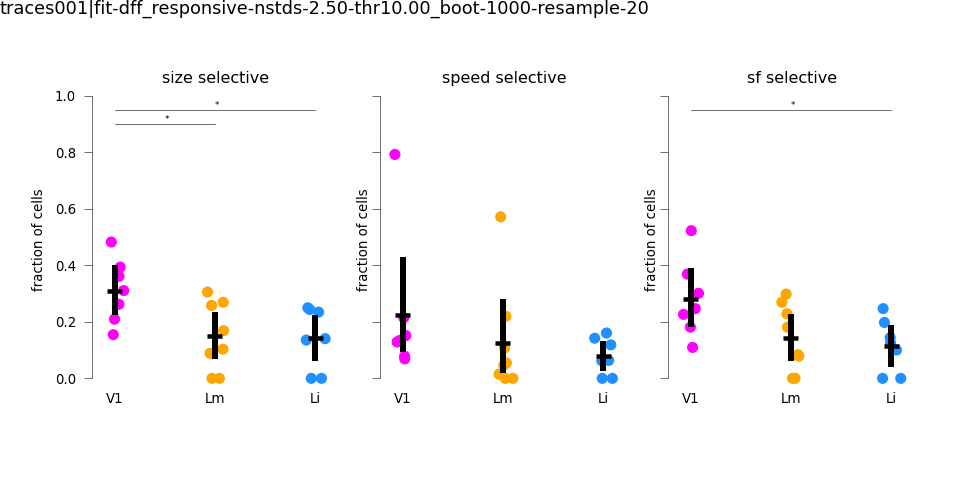

********* [fraction_size] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.024092    9.0   7   8
1  V1  Li    True  0.024092    6.0   7   7
2  Lm  Li   False  0.385167   25.0   8   7
****************************
********* [fraction_speed] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.088413   14.0   7   8
1  V1  Li   False  0.088413   11.0   7   7
2  Lm  Li   False  0.430476   26.0   8   7
****************************
********* [fraction_sf] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.054445   12.0   7   8
1  V1  Li    True  0.044493    7.0   7   7
2  Lm  Li   False  0.385167   25.0   8   7
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics fractioN_nonori_selective_drop_repeats


In [320]:
fig, axn = pl.subplots(1,len(paramnames), figsize=(6,3), sharey=True, sharex=True)
for ax, p in zip(axn.flat, paramnames):
    sns.stripplot(x='visual_area', y='fraction_%s' % p, data=final_counts, ax=ax,
        hue='visual_area', palette=area_colors, order=visual_areas ,zorder=-1)
    sns.pointplot(x='visual_area', y='fraction_%s' % p, data=final_counts, ax=ax,
        color='k', markers='_', scale=1, errwidht=0.5, order=visual_areas, 
                  join=False, zorder=10000)
    pplot.plot_mannwhitney(final_counts, metric='fraction_%s' % p, ax=ax,
                        multi_comp_test=multi_comp_test,
                        y_loc=0.9, offset=0.05, lw=0.25,fontsize=4)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_title("%s selective" % p)
    ax.set_xlabel('')
    ax.set_ylim([-0.02, 1])
    ax.set_yticks(np.linspace(0, 1, 6))
    sns.despine(bottom=True, trim=True, offset=2)
    ax.set_ylabel("fraction of cells")
pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8, right=0.95) 
pplot.label_figure(fig, data_id)

figname = 'fractioN_nonori_selective_%s' % (dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [287]:
final_counts

,visual_area,datakey,tuned,direction_selective,fraction_dsi,axis_selective,fraction_asi,visual,fraction_tuned,pass_gof,fraction_gof,animalid,fov,session,sf_selective,size_selective,speed_selective,fraction_size,fraction_speed,fraction_sf
Li_20190314_JC070_fov1,Li,20190314_JC070_fov1,31,15,0.483871,1.0,0.032258,137,0.226277,16,0.116788,JC070,FOV1_zoom2p0x,20190314,0.0,0.0,0.0,0.000000,0.000000,0.000000
Li_20190315_JC070_fov2,Li,20190315_JC070_fov2,6,5,0.833333,0.0,0.000000,102,0.058824,5,0.049020,JC070,FOV2_zoom2p0x,20190315,0.0,0.0,0.0,0.000000,0.000000,0.000000
Li_20190522_JC089_fov1,Li,20190522_JC089_fov1,7,4,0.571429,1.0,0.142857,32,0.218750,5,0.156250,JC089,FOV1_zoom2p0x,20190522,4.0,8.0,2.0,0.250000,0.062500,0.125000
Li_20190602_JC091_fov1,Li,20190602_JC091_fov1,59,20,0.338983,1.0,0.016949,197,0.299492,20,0.101523,JC091,FOV1_zoom2p0x,20190602,39.0,48.0,28.0,0.243655,0.142132,0.197970
Li_20190612_JC099_fov1,Li,20190612_JC099_fov1,15,5,0.333333,0.0,0.000000,118,0.127119,5,0.042373,JC099,FOV1_zoom2p0x,20190612,17.0,16.0,14.0,0.135593,0.118644,0.144068
Li_20190614_JC091_fov1,Li,20190614_JC091_fov1,39,10,0.256410,2.0,0.051282,299,0.130435,12,0.040134,JC091,FOV1_zoom2p0x,20190614,30.0,42.0,19.0,0.140468,0.063545,0.100334
Li_20191018_JC113_fov1,Li,20191018_JC113_fov1,20,5,0.250000,1.0,0.050000,81,0.246914,6,0.074074,JC113,FOV1_zoom2p0x,20191018,20.0,19.0,13.0,0.234568,0.160494,0.246914
Lm_20190306_JC061_fov2,Lm,20190306_JC061_fov2,66,24,0.363636,7.0,0.106061,219,0.301370,31,0.141553,JC061,FOV2_zoom2p0x,20190306,0.0,0.0,0.0,0.000000,0.000000,0.000000
Lm_20190314_JC070_fov2,Lm,20190314_JC070_fov2,48,9,0.187500,4.0,0.083333,301,0.159468,13,0.043189,JC070,FOV2_zoom2p0x,20190314,0.0,0.0,0.0,0.000000,0.000000,0.000000
Lm_20190512_JC083_fov1,Lm,20190512_JC083_fov1,107,10,0.093458,0.0,0.000000,271,0.394834,10,0.036900,JC083,FOV1_zoom2p0x,20190512,73.0,70.0,155.0,0.258303,0.571956,0.269373


#### Test nonori w/ single FOV

In [193]:
va='V1'
dk ='20190617_JC097_fov1'
# va='Li'
# dk ='20190602_JC091_fov1'
rdf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
sdf = p3.get_stimuli(dk, 'gratings')
# Add stimulus info
for p in paramnames:
    rdf[p] = sdf.loc[rdf['config']][p].values

In [129]:
# Do bootstrap
# R = rdf.groupby('cell').apply(bootstrap_and_evaluate_nonori, sdf=sdf)
# R.head()

,sf,size,speed,cell
cell,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,2.0
3,0.0,1.0,0.0,3.0
5,0.0,0.0,0.0,5.0


In [131]:
R.loc[rid]

sf         1.0
size       0.0
speed      1.0
cell     155.0
Name: 155, dtype: float64

In [232]:
# x_=[]
# for param in paramnames:
#     ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
#     ixs_ = pd.DataFrame(ixs0, columns=['value'])
#     ixs_['metric'] = param
#     ixs_['cell'] = ixs_.index
#     x_.append(ixs_.reset_index(drop=True))
# curr_ixs = pd.concat(x_, axis=0)


In [224]:
ixs_ = rdf.groupby(['cell']).apply(calculate_nonori_index, param='size')

In [228]:
rid=280
rd = rdf[rdf['cell']==rid].copy()

In [230]:
param='size'
vmin = rd['response'].min()
if vmin < 0:
    rd['response'] = rd['response'] - vmin
lo, hi = rd[param].unique().min(), rd[param].unique().max()
v1 = rd[rd[param]==lo]['response'].mean() 
v2 = rd[rd[param]==hi]['response'].mean() 
ix = (v2-v1)/(v1+v2) 
print(param, ix)

size -0.09436637992575322


In [177]:
rid = 280 #155
rd = rdf[rdf['cell']==rid].copy()
trial_vals = get_trial_df(rd)
true_ = index_from_samples(trial_vals, sdf=sdf)


In [178]:
iterd = bootstrap_index_calculation(rd, sdf=sdf, 
                        n_bootstrap_iters=n_bootstrap_iters)
reject_ = check_null(iterd, alpha=alpha)
reject_['cell'] = float(rd['cell'].unique())

alpha=95
sf_lo, sz_lo, sp_lo = np.percentile(iterd, (100-alpha)/2, axis=0)
sf_hi, sz_hi, sp_hi = np.percentile(iterd, alpha+((100-alpha)/2), axis=0)
param_cis = [(sf_lo, sf_hi), (sz_lo, sz_hi), (sp_lo, sp_hi)]


<IPython.core.display.Javascript object>


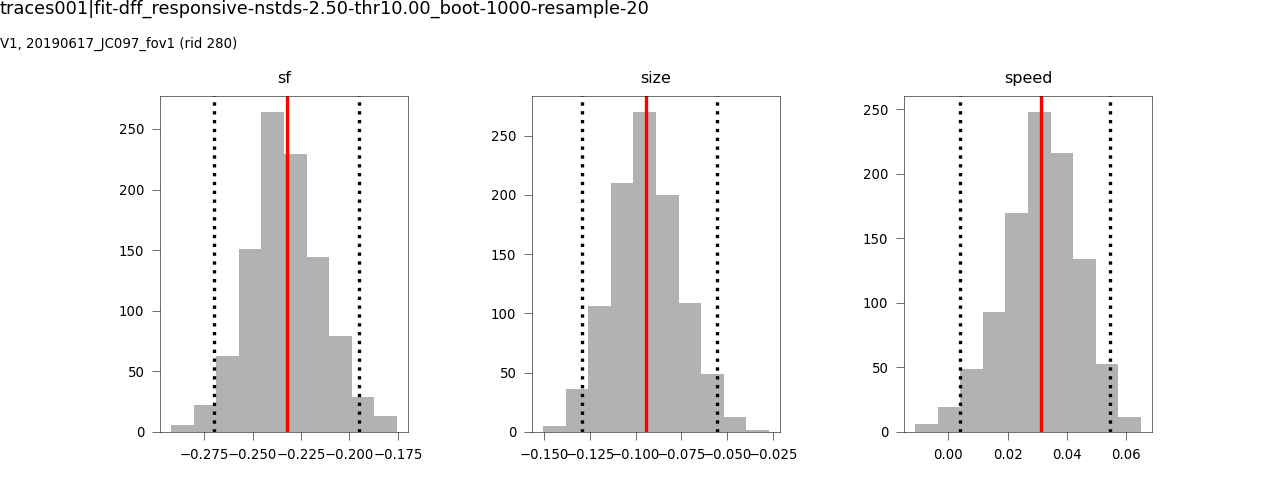

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics examples nonori_V1_20190617_JC097_fov1_rid280


In [179]:

pvals=[]
fig, axes = pl.subplots(1, 3, figsize=(8, 3))
for ax, param, ci_ in zip(axes.flat, ['sf', 'size', 'speed'], param_cis):
    iter_vs = iterd[param]
    ax.hist(iter_vs, color='k', alpha=0.3)
    reject_null = ~(ci_[0] < 0 < ci_[1])
    #ci_upper2 = np.percentile(ordered, alpha)
    true_v = float(true_[param])
    if reject_null:
        lcolor ='r'
    else:
        lcolor = 'k'
    ax.axvline(x=ci_[0], color='k', linestyle=':')
    ax.axvline(x=ci_[1], color='k', linestyle=':')
    ax.axvline(x=true_v, color=lcolor)
    ax.set_title(param)
    nonsig = ci_lower <= true_v<= ci_upper
    pvals.append(not nonsig)
fig.text(0, 0.9, '%s, %s (rid %i)' % (va, dk, rid))
pplot.label_figure(fig, data_id)
pl.subplots_adjust(wspace=0.5, hspace=0.8, top=0.8, bottom=0.1)

figname = 'nonori_%s_%s_rid%i' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, 'examples', '%s.svg' % figname))
print(curr_dst_dir, 'examples', figname)

In [181]:
true_

sf      -0.232310
size    -0.094366
speed    0.031167
dtype: float64

In [182]:
r_.loc[rid]

size    -0.094366
speed    0.031167
sf      -0.232310
Name: 280, dtype: float64

In [109]:
sf_lo, sz_lo, sp_lo = np.percentile(testd, (100-alpha)/2, axis=0)
sf_hi, sz_hi, sp_hi = np.percentile(testd, alpha+((100-alpha)/2), axis=0)
print(sf_lo, sz_lo, sp_lo)

-0.07162004857895753 -0.011886071667971395 -0.02623979624770266


In [101]:
sf_hi, sz_hi, sp_hi = np.percentile(testd, alpha+((100-alpha)/2), axis=0)

array([-0.05118127,  0.01001683, -0.00581061])

In [106]:
reject_null = (ci_lower < 0 < ci_upper)
reject_null

False

In [96]:
R = rdf.groupby(['cell']).apply(bootstrap_index_calculation, 
                            sdf=sdf, n_bootstrap_iters=100)

In [354]:
len(reliable_rois[reliable_rois==True].index.tolist())


60

In [355]:
len(rdf['cell'].unique())

65

In [332]:
rid = 0 #155 #280 #262 # Pref. sf=0.1
rd = rdf[rdf['cell']==rid].copy()

In [333]:
iters = bootstrap_nonori(rd)
is_r = is_reliable_or_no(rd, iters)
print(is_r)
# if is_r:
#     reliable_rois.append(rid)
        
        
# reliabe_=[]
# for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#     iter_vs = iters[(iters['size']==sz) & (iters['sf']==sf) & (iters['speed']==sp)]
#     ordered = sorted(iter_vs['response'])
#     ci_lower = np.percentile(ordered, (100-alpha)/2)
#     ci_upper = np.percentile(ordered, alpha+((100-alpha)/2))
#     true_v =float(g['response'].mean())
#     r_val = ci_lower>0 and (ci_lower<true_v<ci_upper)
#     reliable_.append(r_val)
# if any(reliable_):
#     reliable_rois.append(rid)

True


In [283]:
figname = 'nonori_%s_%s_rid%i' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, 'examples', '%s.svg' % figname))
print(curr_dst_dir, 'examples', figname)

'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics'

In [325]:
p_ixs={}
for p in paramnames:
    lo, hi = rd[p].unique().min(), rd[p].unique().max()
    v1 = rd[rd[p]==lo]['response'].mean() 
    v2 = rd[rd[p]==hi]['response'].mean() 
    ix = (v1-v2)/(v1+v2) # +1 smaller preferred, -1 bigger val preferred
    p_ixs.update({p: ix})
pd.DataFrame(p_ixs, index=[rid])

,size,speed,sf
280,0.374773,-0.123779,0.922612


In [317]:
(v1-v2)/(v1+v2)

0.9226119166018091

In [318]:
rid

280